**Грамматика**

```
<выражение> ->
    <арифметическое выражение> <знак операции отношения> <арифметическое выражение>

<арифметическое выражение> ->
    <терм> |
    <знак операции типа сложение> <терм> |
    <арифметическое выражение> <знак операции типа сложение> <терм>

<терм> ->
    <множитель> |
    <терм> <знак операции типа умножение> <множитель>

<множитель> ->
    <первичное выражение> |
    <множитель> ^ <первичное выражение>

<первичное выражение> ->
    <число> |
    <идентификатор> |
    ( <арифметическое выражение> )

<знак операции типа сложение> ->
    + | -

<знак операции типа умножение> ->
    * | / | %

<знак операции отношения> ->
    < | <= | = | >= | > | <>
```

Преобразованная грамматика


```
<выражение> ->
    <арифметическое выражение> <знак операции отношения> <арифметическое выражение>

<арифметическое выражение> ->
    [ <знак операции типа сложение> ] <терм> { <знак операции типа сложение> <терм> }

<терм> ->
    <множитель> [ <знак операции типа умножение> <терм> ]

<множитель> ->
    <первичное выражение> [ ^ <множитель> ]

<первичное выражение> ->
    <число> |
    <идентификатор> |
    ( <арифметическое выражение> )

<знак операции типа сложение> ->
    + | -

<знак операции типа умножение> ->
    * | / | %

<знак операции отношения> ->
    < | <= | = | >= | > | <>
```

```
<программа> ->
    <блок>

<блок> ->
    { <список операторов> }

<список  операторов> ->
    <оператор> <хвост>

<хвост> ->
    ; <оператор> <хвост>  |  \eps
```

In [1]:
from __future__ import annotations


class ParseNode:
    data = ""
    children: list[ParseNode]
    from_ = -1
    to_ = -1

    def __init__(self, data) -> None:
        self.data = data
        self.children = []
        pass

    def add_child(self, node: ParseNode):
        if not len(self.children):
            self.from_ = node.from_
        self.to_ = node.to_

        if node.data in ["<proxy>"]:
            for ch in node.children:
                self.add_child(ch)
            return

        self.children.append(node)

    def print(self, tree=None, parent="", id="main"):
        from graphviz import Digraph

        if not tree:
            tree = Digraph()
            tree.node_attr["shape"] = "plain"
        tree.node(id, str(self.data))
        if parent:
            tree.edge(parent, id)

        # print("IN:",  self.data, [ch.data for ch in self.children])
        for i, child in enumerate(self.children):
            child.print(tree, id, id + "." + str(i))
        # print("OUT:",  self.data, [ch.data for ch in self.children])

        return tree

In [2]:
import IPython


def test(func, tests: tuple[str, str], full, cmp=lambda a, b: repr(a) == repr(b)):
    output = "<table><thead><tr><td><div style='width:200px'>Вход</div></td><td><div style='width:200px'>Ожидаемый результат</div></td><td><div style='width:200px'>Действительный результат</div></td><td>Комментарий</td></tr></thead><tbody>"
    for test in tests:
        l = func(test[0])
        res = cmp(l, test[1])
        if not res or full:
            output += "<tr><td>\n\n{:}\n</td><td>\n\n{:}\n</td><td>\n\n{:}</td><td>\n\n{:}\n</td></tr>\n".format(
                repr(test[0]),
                repr(test[1]),
                repr(l),
                "OK" if res else "ERROR",
            )
    output += "</tbody></table>"
    return output


In [3]:
from __future__ import annotations

def make_parse_lexem(lexem: str):
    def parse_lexem(lexems: list[str], startPos: int):
        if startPos >= len(lexems):
            return None
        if lexems[startPos] == lexem:
            tree = ParseNode(lexem)
            tree.from_ = startPos
            tree.to_ = startPos + 1
            return tree
        return None

    return parse_lexem


def make_choice(rules):
    def combinator(lexems: list[str], startPos: int):
        for rule in rules:
            node = rule(lexems, startPos)
            if not node:
                continue
            tree = ParseNode("<proxy>")
            tree.add_child(node)
            return tree

        return None

    return combinator


def make_combine(rules):
    def combinator(lexems: list[str], startPos: int):
        tree = ParseNode("<proxy>")
        curPos = startPos
        for rule in rules:
            node = rule(lexems, curPos)
            if not node:
                return None

            tree.add_child(node)
            curPos = node.to_
        return tree

    return combinator


def make_loop(rule):
    def looper(lexems: typing.List[str], startPos: int):
        tree = ParseNode("<proxy>")
        tree.from_ = startPos
        tree.to_ = startPos

        curPos = startPos
        while True:
            node = rule(lexems, curPos)
            if not node:
                break
            curPos = node.to_
            tree.add_child(node)

        return tree

    return looper


def make_optional(rule):
    def ret_empty(pos):
        node = ParseNode("<proxy>")
        node.from_ = pos
        node.to_ = pos
        return node

    def opter(lexems: list[str], startPos: int):
        node = rule(lexems, startPos)
        if not node:
            return ret_empty(startPos)
        return node

    return opter


def parse_rel_op(lexems: list[str], startPos: int) -> ParseNode | None:
    tree = make_choice(
        [
            make_parse_lexem("<"),
            make_parse_lexem("<="),
            make_parse_lexem("="),
            make_parse_lexem(">="),
            make_parse_lexem(">"),
            make_parse_lexem("!="),
        ]
    )(lexems, startPos)
    if not tree:
        return None

    tree.data = "<операция отношения>"
    return tree


def parse_mult_op(lexems: list[str], startPos: int) -> ParseNode | None:
    tree = make_choice(
        [
            make_parse_lexem("*"),
            make_parse_lexem("/"),
            make_parse_lexem("%"),
        ]
    )(lexems, startPos)
    if not tree:
        return None

    tree.data = "<операция типа умножение>"
    return tree


def parse_sum_op(lexems: list[str], startPos: int) -> ParseNode | None:
    tree = make_choice(
        [
            make_parse_lexem("+"),
            make_parse_lexem("-"),
        ]
    )(lexems, startPos)
    if not tree:
        return None

    tree.data = "<операция типа сложение>"
    return tree


def parse_id(lexems: list[str], startPos: int) -> ParseNode | None:
    if startPos >= len(lexems):
        return None
    tree = ParseNode("<идентификатор>")

    data = lexems[startPos]
    if not data.isalpha():
        return None

    node = ParseNode(data)
    node.from_ = startPos
    node.to_ = startPos + 1

    tree.add_child(node)
    return tree


def parse_num(lexems: list[str], startPos: int) -> ParseNode | None:
    if startPos >= len(lexems):
        return None

    tree = ParseNode("<число>")

    try:
        data = float(lexems[startPos])
    except:
        return None

    node = ParseNode(data)
    node.from_ = startPos
    node.to_ = startPos + 1

    tree.add_child(node)
    return tree


def parse_first_exp(lexems: list[str], startPos: int) -> ParseNode | None:
    tree = make_choice(
        [
            make_combine(
                [
                    make_parse_lexem("("),
                    parse_arythmetical_stmt,
                    make_parse_lexem(")"),
                ]
            ),
            parse_id,
            parse_num,
        ]
    )(lexems, startPos)
    if not tree:
        return None

    tree.data = "<первичное выражение>"
    return tree


def parse_multiplier(lexems: list[str], startPos: int) -> ParseNode | None:
    tree = make_combine(
        [
            parse_first_exp,
            make_optional(make_combine([make_parse_lexem("^"), parse_multiplier])),
        ]
    )(lexems, startPos)
    if not tree:
        return None

    tree.data = "<множитель>"
    return tree


def parse_term(lexems: list[str], startPos: int) -> ParseNode | None:
    tree = make_combine(
        [parse_multiplier, make_optional(make_combine([parse_mult_op, parse_term]))]
    )(lexems, startPos)
    if not tree:
        return None

    tree.data = "<терм>"
    return tree


def parse_arythmetical_stmt(lexems: list[str], startPos: int) -> ParseNode | None:
    tree = make_combine(
        [
            make_optional(parse_sum_op),
            parse_term,
            make_loop(
                make_combine(
                    [
                        parse_sum_op,
                        parse_term,
                    ]
                )
            ),
        ]
    )(lexems, startPos)
    if not tree:
        return None

    tree.data = "<арифметическое выражение>"
    return tree


def parse_expr(lexems: list[str], startPos: int) -> ParseNode | None:
    tree = make_combine(
        [
            parse_arythmetical_stmt,
            parse_rel_op,
            parse_arythmetical_stmt,
        ]
    )(lexems, startPos)
    if not tree:
        return None

    tree.data = "<выражение>"

    return tree

In [4]:
report = test(
    lambda x: parse_expr(x, 0),
    [
        (
            ["1"],
            None,
        ),
        (
            ["1", "<>", "2"],
            None,
        ),
        (
            ["1", "=", "2"],
            {},
        ),
        (
            ["x", "^", "2", "-", "x", "+", "1", ">", "e", "^", "(", "x", "^", "2", ")"],
            {},
        ),
    ],
    True,
    lambda a, b: a is not None or repr(a) == repr(b),
)


IPython.display.Markdown(report)

<table><thead><tr><td><div style='width:200px'>Вход</div></td><td><div style='width:200px'>Ожидаемый результат</div></td><td><div style='width:200px'>Действительный результат</div></td><td>Комментарий</td></tr></thead><tbody><tr><td>

['1']
</td><td>

None
</td><td>

None</td><td>

OK
</td></tr>
<tr><td>

['1', '<>', '2']
</td><td>

None
</td><td>

None</td><td>

OK
</td></tr>
<tr><td>

['1', '=', '2']
</td><td>

{}
</td><td>

<__main__.ParseNode object at 0x1119127d0></td><td>

OK
</td></tr>
<tr><td>

['x', '^', '2', '-', 'x', '+', '1', '>', 'e', '^', '(', 'x', '^', '2', ')']
</td><td>

{}
</td><td>

<__main__.ParseNode object at 0x111911c90></td><td>

OK
</td></tr>
</tbody></table>

In [5]:
def tokenize(code: str):
    tokens = []
    curPos = 0
    while curPos < len(code):
        if code[curPos : min(curPos + 2, len(code))] in ["<=", ">=", "!="]:
            tokens += [code[curPos : min(curPos + 2, len(code))]]
            curPos += 2
        elif code[curPos] in ['+', '-', '*', '/', '%', '<', '=', '>', '(', ')', '{', '}', ';', '^']:
            tokens += [code[curPos]]
            curPos += 1
        elif code[curPos] in [" ", "\t", "\n", "\r"]:
            curPos += 1
        else:
            startpos = curPos
            while curPos < len(code) and (
                code[curPos].isalpha()
                or code[curPos].isnumeric()
                or code[curPos] in ["_", "."]
            ):
                curPos += 1
            tokens += [code[startpos:curPos]]
            if startpos == curPos:
                print("ERROR")
                break
        # print(tokens[-1])
    return tokens

['1', '*', '2', '^', '1', '!=', '2']


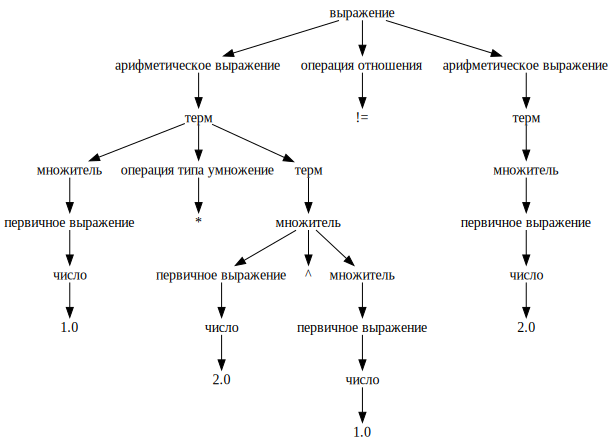

In [6]:
code = "1 * 2 ^ 1 != 2"
print(tokenize(code))
tree = parse_expr(tokenize(code), 0)
tree.print()

In [7]:
report = test(
    tokenize,
    [
        (
            "1 > 2",
            ["1", ">", "2"],
        ),
        (
            "(1 + 1) > 2",
            ["(", "1", "+", "1", ")", ">", "2"],
        ),
        (
            "(1 * a - 4 ^ 2) > 2",
            ["(", "1", "*", "a", "-", "4", "^", "2", ")", ">", "2"],
        ),
        (
            "x^2 - x +1 > e^(x^2)",
            ["x", "^", "2", "-", "x", "+", "1", ">", "e", "^", "(", "x", "^", "2", ")"],
        ),
        (
            "{ a = 1 > 2; b = x^2 - x +1 > e^(x^2); }",
            ["{", "a", "=", "1", ">", "2", ";", "b", "=", "x", "^", "2", "-", "x", "+", "1", ">", "e", "^", "(", "x", "^", "2", ")", ";", "}"],
        ),
    ],
    True,
)


IPython.display.Markdown(report)

<table><thead><tr><td><div style='width:200px'>Вход</div></td><td><div style='width:200px'>Ожидаемый результат</div></td><td><div style='width:200px'>Действительный результат</div></td><td>Комментарий</td></tr></thead><tbody><tr><td>

'1 > 2'
</td><td>

['1', '>', '2']
</td><td>

['1', '>', '2']</td><td>

OK
</td></tr>
<tr><td>

'(1 + 1) > 2'
</td><td>

['(', '1', '+', '1', ')', '>', '2']
</td><td>

['(', '1', '+', '1', ')', '>', '2']</td><td>

OK
</td></tr>
<tr><td>

'(1 * a - 4 ^ 2) > 2'
</td><td>

['(', '1', '*', 'a', '-', '4', '^', '2', ')', '>', '2']
</td><td>

['(', '1', '*', 'a', '-', '4', '^', '2', ')', '>', '2']</td><td>

OK
</td></tr>
<tr><td>

'x^2 - x +1 > e^(x^2)'
</td><td>

['x', '^', '2', '-', 'x', '+', '1', '>', 'e', '^', '(', 'x', '^', '2', ')']
</td><td>

['x', '^', '2', '-', 'x', '+', '1', '>', 'e', '^', '(', 'x', '^', '2', ')']</td><td>

OK
</td></tr>
<tr><td>

'{ a = 1 > 2; b = x^2 - x +1 > e^(x^2); }'
</td><td>

['{', 'a', '=', '1', '>', '2', ';', 'b', '=', 'x', '^', '2', '-', 'x', '+', '1', '>', 'e', '^', '(', 'x', '^', '2', ')', ';', '}']
</td><td>

['{', 'a', '=', '1', '>', '2', ';', 'b', '=', 'x', '^', '2', '-', 'x', '+', '1', '>', 'e', '^', '(', 'x', '^', '2', ')', ';', '}']</td><td>

OK
</td></tr>
</tbody></table>

Вариант в стиле Си.

```
<программа> ->
    <блок>

<блок> ->
    { <список операторов> }

<список  операторов> ->
    <оператор> <хвост>

<хвост> ->
    ; <оператор> <хвост>  |  \eps
```
 ====


Преобразованный вариант в стиле Си.

```
<программа> ->
    <блок>

<блок> ->
    "{" <список операторов> "}"

<список  операторов> ->
    <оператор> { ";"  <оператор> } ";"

<оператор> ->
    <идентификатор>  = <выражение>

```

In [8]:
def parse_operator(lexems: list[str], startPos: int) -> ParseNode | None:
    tree = make_combine([parse_id, make_parse_lexem("="), parse_expr])(lexems, startPos)
    if not tree:
        return None

    tree.data = "<оператор>"

    return tree


def parse_operator_list(lexems: list[str], startPos: int) -> ParseNode | None:
    tree = make_combine(
        [
            parse_operator,
            make_loop(
                make_combine(
                    [
                        make_parse_lexem(";"),
                        parse_operator,
                    ]
                )
            ),
            make_parse_lexem(";"),
        ]
    )(lexems, startPos)
    if not tree:
        return None

    tree.data = "<список  операторов>"

    return tree


def parse_block(lexems: list[str], startPos: int) -> ParseNode | None:
    tree = make_combine(
        [
            make_parse_lexem("{"),
            parse_operator_list,
            make_parse_lexem("}"),
        ]
    )(lexems, startPos)
    if not tree:
        return None

    tree.data = "<блок>"

    return tree


def parse_program(lexems: list[str], startPos: int) -> ParseNode | None:
    tree = ParseNode("<выражение>")

    node = parse_block(lexems, startPos)
    if not node:
        return None

    tree.add_child(node)

    return tree


['{', 'one', '=', '(', '4', '+', '(', '6', '^', '11', ')', ')', '>', '10', ';', 'two', '=', '(', '0.5', '^', '11', '+', '13', '^', '0.5', ')', '!=', '1', ';', '}']


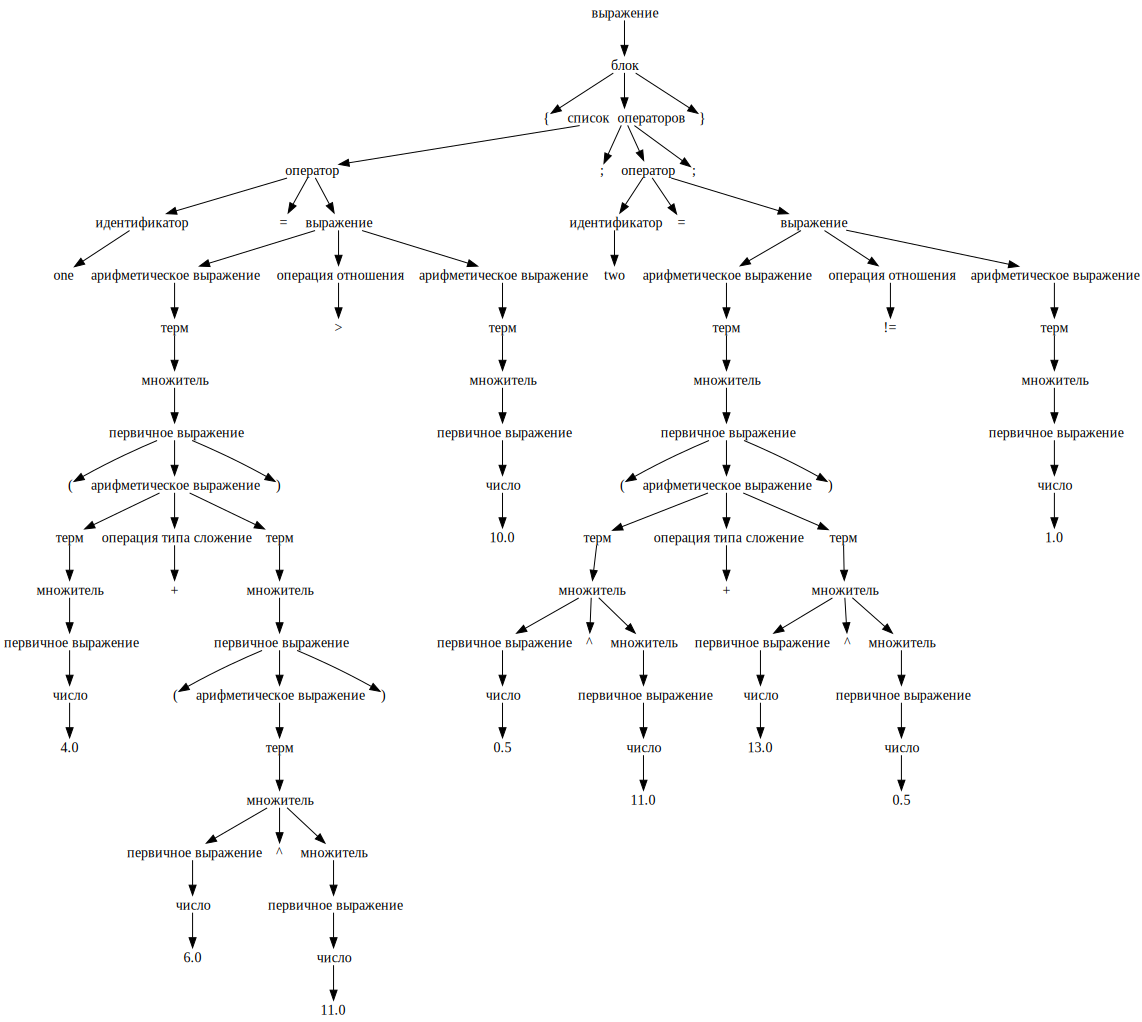

In [9]:
code = """
{
    one = (4 + (6 ^ 11)) > 10;
    two = (0.5 ^ 11 + 13 ^ 0.5) != 1;
}
"""

print(tokenize(code))
tree = parse_program(tokenize(code), 0)
tree.print()

In [10]:
report = test(
    lambda x: parse_program(x, 0),
    [
        (
            ["1"],
            None,
        ),
        (
            ["1", "!=", "2"],
            None,
        ),
        (
            ["{", "1", "=", "2", ">", "3", ";", "}"],
            None,
        ),
        (
            ["{", "a", "=", "2", ">", "3", ";", "}"],
            {},
        ),
        (
            ["{", "b", "=", "x", "^", "2", "-", "x", "+", "1", ">", "e", "^", "(", "x", "^", "2", ")", ";", "}"],
            {},
        ),
    ],
    True,
    lambda a, b: a is not None or repr(a) == repr(b),
)


IPython.display.Markdown(report)

<table><thead><tr><td><div style='width:200px'>Вход</div></td><td><div style='width:200px'>Ожидаемый результат</div></td><td><div style='width:200px'>Действительный результат</div></td><td>Комментарий</td></tr></thead><tbody><tr><td>

['1']
</td><td>

None
</td><td>

None</td><td>

OK
</td></tr>
<tr><td>

['1', '!=', '2']
</td><td>

None
</td><td>

None</td><td>

OK
</td></tr>
<tr><td>

['{', '1', '=', '2', '>', '3', ';', '}']
</td><td>

None
</td><td>

None</td><td>

OK
</td></tr>
<tr><td>

['{', 'a', '=', '2', '>', '3', ';', '}']
</td><td>

{}
</td><td>

<__main__.ParseNode object at 0x11199d510></td><td>

OK
</td></tr>
<tr><td>

['{', 'b', '=', 'x', '^', '2', '-', 'x', '+', '1', '>', 'e', '^', '(', 'x', '^', '2', ')', ';', '}']
</td><td>

{}
</td><td>

<__main__.ParseNode object at 0x11199e290></td><td>

OK
</td></tr>
</tbody></table>